In [212]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
# from scipy.signal import firwin, periodogram, lfilter 
from scipy.signal import *


In [213]:

def rrcf(N, beta, Ts, Fs):

    T_delta = 1.0 / Fs
    time_index = np.arange(-N / 2, N / 2) * T_delta
    # sample_num = np.arange(-N / 2, N / 2)

    h_rrc = np.zeros(len(time_index), dtype=float)

    for idx, t in enumerate(time_index):
        if t == 0.0:
            h_rrc[idx] = 1.0 - beta + (4 * beta / np.pi)
        elif beta != 0 and t == Ts / (4 * beta):
            h_rrc[idx] = (beta / np.sqrt(2)) * (
                ((1 + 2 / np.pi) * (np.sin(np.pi / (4 * beta))))
                + ((1 - 2 / np.pi) * (np.cos(np.pi / (4 * beta))))
            )
        elif beta != 0 and t == -Ts / (4 * beta):
            h_rrc[idx] = (beta / np.sqrt(2)) * (
                ((1 + 2 / np.pi) * (np.sin(np.pi / (4 * beta))))
                + ((1 - 2 / np.pi) * (np.cos(np.pi / (4 * beta))))
            )
        else:
            h_rrc[idx] = (
                np.sin(np.pi * t * (1 - beta) / Ts)
                + 4 * beta * (t / Ts) * np.cos(np.pi * t * (1 + beta) / Ts)
            ) / (np.pi * t * (1 - (4 * beta * t / Ts) ** 2) / Ts)

    return time_index, h_rrc



In [214]:

num_symbols = 20
sps = 8

bits = np.random.randint(
    0, 2, num_symbols * 2
)  # Our data to be transmitted, 1's and 0's
print(bits)

[1 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 0 0 0 1 1 1 1 0 1 1 1 0 1
 0 0 0]


In [215]:

mapping = {
    "00": -3,
    "01": -1,
    "11": 1,
    "10": 3,
}

In [216]:
y = np.array([])
for bit in range(0, len(bits), 2):
    bit_mapping = str(bits[bit]) + str(bits[bit + 1])
    pulse = np.zeros(sps)
    pulse[0] = mapping[bit_mapping]
    y = np.concatenate((y, pulse))

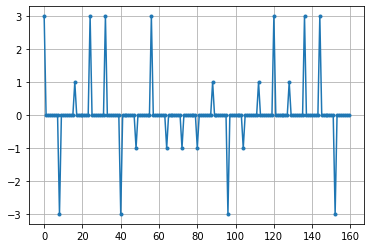

In [217]:
plt.figure(0)
plt.plot(y, ".-")
plt.grid(True)
plt.show()

In [218]:
# Test the function
N = 101
beta = 0.25
Ts = 0.8
Fs = 10

time_index, h_rrc = rrcf(N, beta, Ts, Fs)

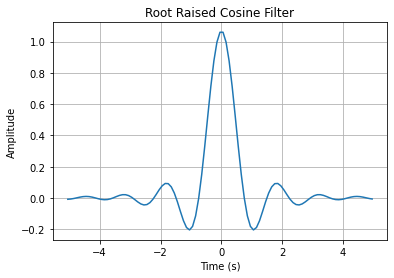

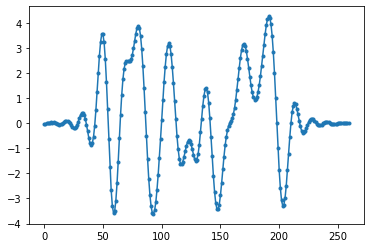

In [219]:

# Plot the filter
plt.figure()
plt.plot(time_index, h_rrc)
plt.title("Root Raised Cosine Filter")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

y_shaped = np.convolve(y, h_rrc)
plt.plot(y_shaped, ".-")
plt.show()

In [220]:

X = np.fft.fftshift(np.fft.fft(y_shaped, 800))
f_axis = np.arange(0, 800) * Fs / 800 - Fs / 2

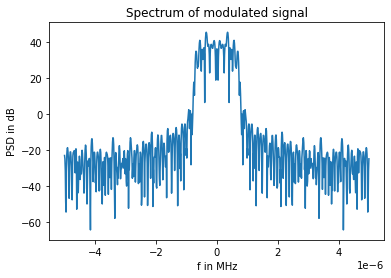

In [221]:
plt.plot(f_axis / 1e6, 20 * np.log10(np.abs(X)))
plt.title("Spectrum of modulated signal")
plt.xlabel("f in MHz")
plt.ylabel("PSD in dB")
plt.show()

In [222]:
taps = 8
x_sq = np.arange(taps)
pulse = np.ones_like(x_sq)

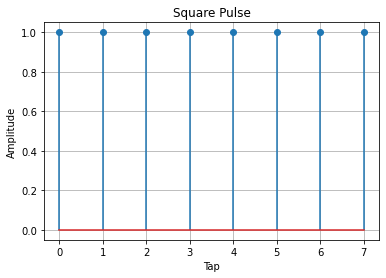

In [223]:
# Plot the square pulse
plt.figure()
plt.stem(pulse, use_line_collection=True)
plt.title("Square Pulse")
plt.xlabel("Tap")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()



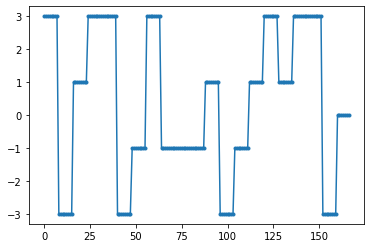

In [224]:

x_shq = np.convolve(y, pulse)
plt.plot(x_shq, ".-")
plt.show()

In [225]:
X = np.fft.fftshift(np.fft.fft(x_shq, 800))
f_axis = np.arange(0, 800) * Fs / 800 - Fs / 2

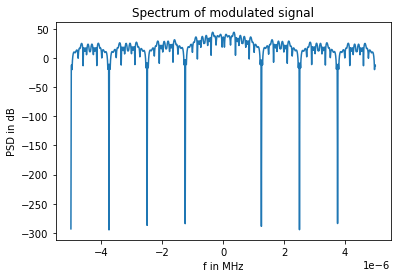

In [226]:

plt.plot(f_axis / 1e6, 20 * np.log10(np.abs(X)))
plt.title("Spectrum of modulated signal")
plt.xlabel("f in MHz")
plt.ylabel("PSD in dB")
plt.show()

In [227]:

rec_conv = np.convolve(x_shq, pulse) / 8

In [228]:
# Taking every 7th asmple
evey_seven_sample = []
length = []
count = 1
for i in range(7, len(rec_conv), 8):
    length.append(count)
    count += 1
    evey_seven_sample.append(rec_conv[i])
    # print(rec_conv[i], end=" ")

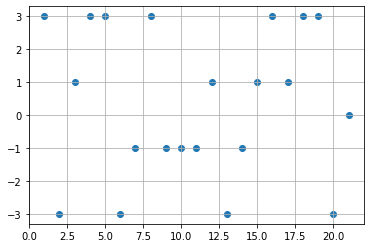

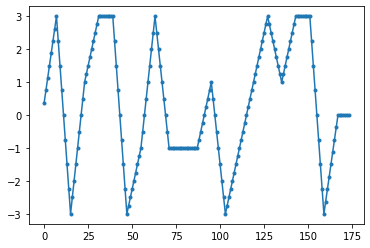

In [229]:

plt.scatter(length, evey_seven_sample)
plt.grid(True)
plt.show()
plt.plot(rec_conv, ".-")
plt.show()

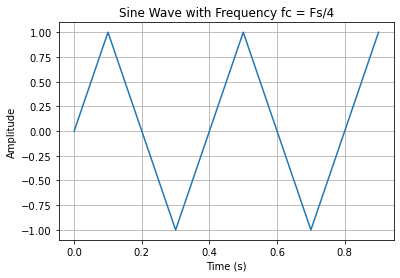

In [230]:
# sine wave generation

# Calculate the frequency of the sine wave (fc = Fs/4)
fc = Fs / 4

# Set the duration of the signal
duration = 1  # in seconds

# Generate time values from 0 to duration with a step size based on the sampling frequency
t = np.arange(0, duration, 1/Fs)

# Generate the sine wave signal
signal = np.sin(2 * np.pi * fc * t)

# Plot the sine wave
plt.plot(t, signal)
plt.title('Sine Wave with Frequency fc = Fs/4')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

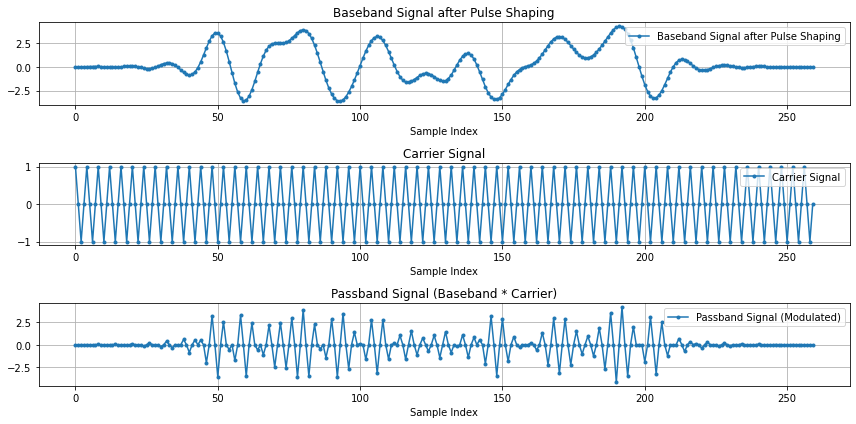

In [231]:

# Generate the carrier signal

n = np.arange(0, len(y_shaped))
carrier = np.cos(2 * np.pi * fc * n / Fs)

# Multiply the baseband signal with the carrier signal to get the passband signal
x_pb = y_shaped * carrier

# Plot the baseband signal, carrier signal, and the passband signal
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(y_shaped, '.-', label='Baseband Signal after Pulse Shaping')
plt.title('Baseband Signal after Pulse Shaping')
plt.xlabel('Sample Index')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(carrier, '.-', label='Carrier Signal')
plt.title('Carrier Signal')
plt.xlabel('Sample Index')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(x_pb, '.-', label='Passband Signal (Modulated)')
plt.title('Passband Signal (Baseband * Carrier)')
plt.xlabel('Sample Index')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

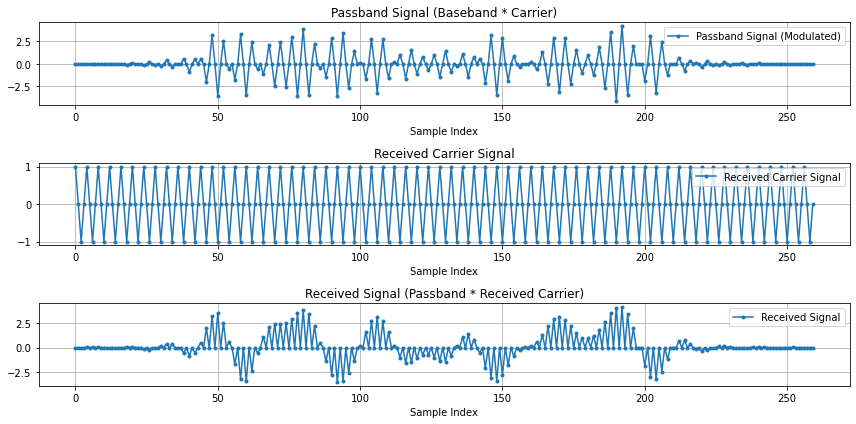

In [232]:

# ... (previous code)

# Generate the received carrier signal
n_rx = np.arange(0, len(x_pb))
carrier_rx = np.cos(2 * np.pi * fc * n_rx / Fs)

# Multiply the passband signal with the received carrier signal
x_rx = x_pb * carrier_rx

# Plot the passband signal, received carrier signal, and the received signal
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(x_pb, '.-', label='Passband Signal (Modulated)')
plt.title('Passband Signal (Baseband * Carrier)')
plt.xlabel('Sample Index')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(carrier_rx, '.-', label='Received Carrier Signal')
plt.title('Received Carrier Signal')
plt.xlabel('Sample Index')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(x_rx, '.-', label='Received Signal')
plt.title('Received Signal (Passband * Received Carrier)')
plt.xlabel('Sample Index')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [233]:
# from scipy.signal import firwin
# from scipy.signal import lfilter


# Designing a low-pass FIR filter
numtaps = 25
f_BW = 5  # Replace with your desired cutoff frequency in Hz
f = f_BW / Fs

print(f)
# h = firwin(numtaps , f)
# print()

0.5


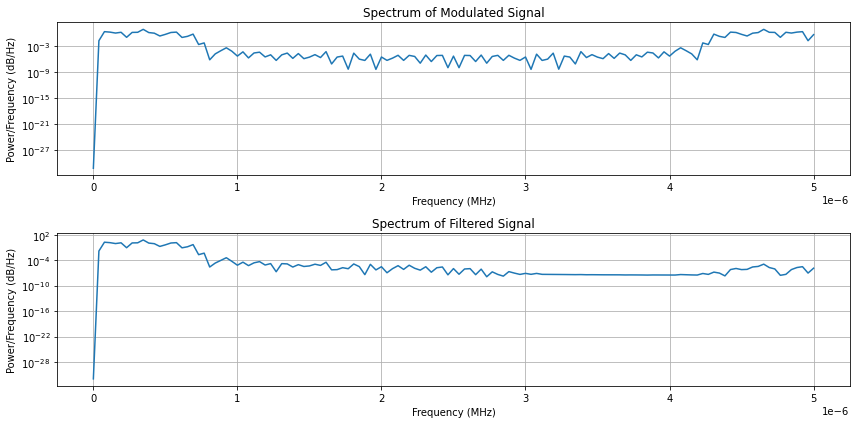

In [234]:
import scipy

#Debugging
h = firwin(numtaps, f)

# Filter the received signal through the LPF
yc = scipy.signal.lfilter(h, 1, x_rx)

# Plot the spectra of the modulated signal and the filtered signal
plt.figure(figsize=(12, 6))

# Plot the spectrum of the modulated signal
plt.subplot(2, 1, 1)
f_mod, Pxx_mod = scipy.signal.periodogram(x_rx, Fs)
plt.semilogy(f_mod / 1e6, Pxx_mod)
plt.title('Spectrum of Modulated Signal')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)

# Plot the spectrum of the filtered signal
plt.subplot(2, 1, 2)
f_filt, Pxx_filt = scipy.signal.periodogram(yc, Fs)
plt.semilogy(f_filt / 1e6, Pxx_filt)
plt.title('Spectrum of Filtered Signal')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)

plt.tight_layout()
plt.show()